In [1]:
#default_exp models.builder

In [2]:
# export
import timm
import torch
from fastcore.all import ifnone
from omegaconf import DictConfig
from timm.models.layers import create_classifier
from torch import nn

from src import _logger
from src.core import *
from src.models.classifiers import *
from src.models.layers import *
from src.models.utils import apply_init, cut_model, num_features_model

In [3]:
print(CLASSIFIER_REGISTERY)

Registry of Classifiers:
╒═══════════╤════════════════════════════════════════════╕
│ Names     │ Objects                                    │
╞═══════════╪════════════════════════════════════════════╡
│ CnnHeadV0 │ <function CnnHeadV0 at 0x7fe624a8a830>     │
├───────────┼────────────────────────────────────────────┤
│ CnnHeadV1 │ <function CnnHeadV1 at 0x7fe624a8acb0>     │
├───────────┼────────────────────────────────────────────┤
│ CnnHeadV2 │ <class 'src.models.classifiers.CnnHeadV2'> │
╘═══════════╧════════════════════════════════════════════╛


In [4]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
from omegaconf import OmegaConf
from timm.data.constants import IMAGENET_DEFAULT_MEAN as mean
from timm.data.constants import IMAGENET_DEFAULT_STD as std
from timm.data.transforms import RandomResizedCropAndInterpolation
from torchvision.utils import make_grid

from src.data.datasets import CassavaDataset, load_data
from src.data.mixmethods import Snapmix

In [9]:
# export
def build_head(cfg: DictConfig, nf, verbose=False):
    "builds a classifier for model with output `nf`"
    head = CLASSIFIER_REGISTERY.get(cfg.name)(nf=nf, **cfg.params)
    return head

In [11]:
cfg1 = OmegaConf.load('../conf/model/v0.yaml')
cfg2 = OmegaConf.load('../conf/model/v1.yaml')
cfg3 = OmegaConf.load('../conf/model/v2.yaml')

cfg1.base_model.name = "tf_efficientnet_b3_ns"
cfg2.base_model.name = "tf_efficientnet_b3_ns"
cfg3.base_model.name = "tf_efficientnet_b3_ns"

cfg1 = OmegaConf.create(dict(model=cfg1))
cfg2 = OmegaConf.create(dict(model=cfg2))
cfg3 = OmegaConf.create(dict(model=cfg3))

## Base model class

In [23]:
# export
class Net(nn.Module):
    "Creates a model using the Global Config"

    def __init__(self, cfg: DictConfig, verbose=True):
        super(Net, self).__init__()
        self.base_conf = cfg.model.base_model
        self.head_conf = cfg.model.head

        # build the encoder
        if verbose:
            _logger.info("Configuration for the current model :")
            _logger.info(f"\tfeature_extractor: {self.base_conf.name}")
            
            if self.base_conf.activation is not None: 
                _logger.info(f"\tactivation: {self.base_conf.activation}")
            
            _logger.info(f"\tparams: {self.base_conf.params}")
                
            for k, v in self.head_conf.items():
                if k == "name": _logger.info(f"\thead: {str(v)}")
                else          : _logger.info(f"\t{k}: {v}")
        
        if self.base_conf.activation is not None:  act = ACTIVATIONS[self.base_conf.activation]
        else                                    :  act = None
        
        self.encoder = timm.create_model(self.base_conf.name, act_layer=act, **self.base_conf.params)
        self.encoder = cut_model(self.encoder, -2)
        nf = num_features_model(self.encoder)
        self.head = build_head(self.head_conf, nf, verbose)
                

    def init_classifier(self):
        if self.clf_conf.act_layer == "default":
            apply_init(self.classifier, torch.nn.init.kaiming_normal_)
        else:
            apply_init(self.classifier, torch.nn.init.kaiming_uniform_)
    
    def get_head(self):
        return self.head

    def get_classifier(self):
        try:
            return self.head[-1]
        except:
            return self.head.fc2

    def forward_features(self, x):
        return self.encoder(x)

    def forward(self):
        return self.head(self.forward_features(x))

    def get_param_list(self):
        return [params(self.encoder), params(self.head)]

In [24]:
model = Net(cfg1)

[01/31 14:14:23 __main__]: Configuration for the current model :
[01/31 14:14:23 __main__]: 	feature_extractor: tf_efficientnet_b3_ns
[01/31 14:14:23 __main__]: 	activation: mish
[01/31 14:14:23 __main__]: 	params: {'drop_path_rate': 0.25}
[01/31 14:14:23 __main__]: 	head: CnnHeadV0
[01/31 14:14:23 __main__]: 	params: {'n_out': 5, 'pool_type': 'avg', 'use_conv': False, 'act_layer': 'mish'}


In [25]:
csv_path = "../../leaf-disease-classification-kaggle/data/stratified-data-5folds.csv"
imgs_dir = "../../Datasets/cassava/train_images/"

df = load_data(csv_path, imgs_dir, curr_fold=0, shuffle=True)

t1 = T.Compose([
    RandomResizedCropAndInterpolation(512, interpolation="random"), 
    T.ToTensor(), 
    T.Normalize(mean, std)])

t2 = T.Compose([
    RandomResizedCropAndInterpolation(512, interpolation="random"), 
    T.ToTensor(), 
    T.ColorJitter(0.1, 0.1, 0.1),
    T.Normalize(mean, std),
    T.RandomErasing(),])

dset = CassavaDataset.from_torchvision_tfms(df, "filePath", label_col="label", transform=t1)
dl = torch.utils.data.DataLoader(dset, batch_size=8)

/Users/ayushman/Desktop/leaf-disease-classification-kaggle/nbs/src/data/mixmethods.py:255: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  clslogit = F.softmax(clsw.forward(poolfea))


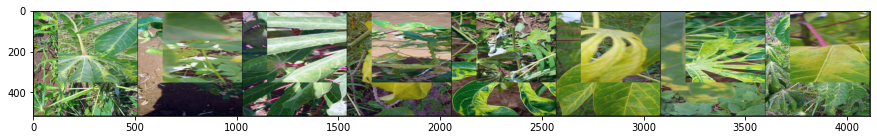

In [26]:
mixmethod = Snapmix()
img, targ = next(iter(dl))

img_mix = mixmethod(img, targ, model)
mixmethod.stop()

grid = make_grid(img_mix, normalize=True).permute(1, 2, 0).numpy()

plt.figure(figsize=(15, 10))
plt.imshow(grid)

In [27]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.datasets.ipynb.
Converted 01a_data.mixmethods.ipynb.
Converted 01b_data.datasests_factory.ipynb.
Converted 02_losses.ipynb.
Converted 03_models.utils.ipynb.
Converted 03a_models.layers.ipynb.
Converted 03b_models.builder.ipynb.
Converted 03b_models.classification.ipynb.
Converted 03b_models.classifiers.ipynb.
Converted 04_optimizers.ipynb.
Converted 04a_schedulers.ipynb.
Converted 05b_lightning.callbacks.ipynb.
Converted index.ipynb.
